In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch import hub
from script import vggish_input, vggish_params
import os

In [ ]:
import torch
model = torch.hub.load('harritaylor/torchvggish', 'vggish')
model.postprocess = False
model.eval()

In [ ]:
def list_sort(x : str):
    if '.' in x:

        x = x.rpartition('_')

        x = x[0][2:4]
    else:
        x = 0
    return int(x)

In [ ]:
device = torch.device('cpu')

In [ ]:
train_data = torch.tensor([])
ss_path = '/scratch/bs4283/auditory_data/data_20sample/training_data_20/'
fileList = os.listdir('/scratch/bs4283/auditory_data/data_20sample/training_data_20/')
fileList.sort(key=list_sort)
for filename in fileList:
    filepath = os.path.join(ss_path,filename)
    with torch.no_grad():  
        re = model(filepath).to(device)
    train_data = torch.cat((train_data,re))

In [ ]:
torch.save(train_data,'/scratch/bs4283/auditory_data/data_20sample/binary_training_data.pt')

In [4]:
device = torch.device('cuda')

In [5]:
train_data = torch.load('/scratch/bs4283/auditory_data/data_20sample/binary_training_data.pt')

In [6]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression,self).__init__()
        self.linear = nn.Linear(128,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        return self.sigmoid(self.linear(x))

In [7]:
def make_train_data(data1,data2):
    data1 = data1.numpy()
    data2 = data2.numpy()
    sub_diff = np.setdiff1d(data2,data1,assume_unique=True)
    
    r2 = torch.randperm(3800)[0:200].numpy()
    ss = torch.from_numpy(data2[sub_diff[r2]])
    return ss

In [8]:
weight_binar = torch.ones([20,128]).to(device)
bias_binar = torch.ones([20]).to(device)
loss_vel_final = torch.tensor([]).to(device)



Iter = np.zeros([20,])
L_tr = np.zeros([20,])
L_va = np.zeros([20,])

In [104]:
hh = 19

loss_vel = np.zeros([9000,1])
loss_tra = np.zeros([9000,1])

weight_bin = torch.tensor([]).to(device)
bias_bin = torch.tensor([]).to(device)

train_x1 = train_data[hh*200:(hh+1)*200,:]
sub = torch.arange(4000)
sub_cat = torch.arange(hh*200,(hh+1)*200,1)
sub_dif = make_train_data(sub_cat,sub)        
train_x2 = train_data[sub_dif,:]
train_x = torch.cat((train_x1[:160,:], train_x2[:160,:]), 0)
val_x  = torch.cat((train_x1[160:,:], train_x2[160:,:]), 0)
y1 = torch.ones(200)
y2 = torch.zeros(200)

train_y = torch.cat((y1[:160],y2[:160]),0).to(device)
val_y = torch.cat((y1[160:],y2[160:]),0).to(device)



model_binary = LogisticRegression().to(device)
loss_fn = nn.BCELoss()
lr = 0.01 
optimizer = torch.optim.Adam(model_binary.parameters(), lr=lr) 

for iteration in range(9000):   
#    loss_pre  = loss_val
    y_pred = model_binary(train_x.to(device)).to(device)             
    loss = loss_fn(y_pred.squeeze(), train_y)   
    loss.requires_grad_(True)
    optimizer.zero_grad()
    loss.backward()              
    optimizer.step()   

    y_val_pre = model_binary(val_x.to(device)).to(device)
    loss_val = loss_fn(y_val_pre.squeeze(), val_y)
    
    loss_vel[iteration] = loss_val.cpu().detach().numpy()
    loss_tra[iteration] = loss.cpu().detach().numpy()
    
    ww = model_binary.linear.weight.to(device)
    bi = model_binary.linear.bias.to(device)
    weight_bin = torch.cat((weight_bin.to(device),ww.to(device)))
    bias_bin = torch.cat([bias_bin.to(device),bi.to(device)])

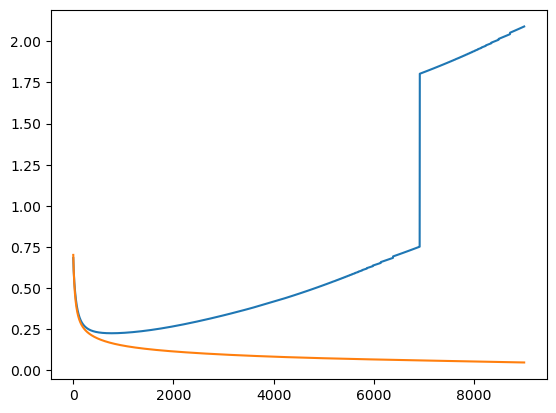

In [105]:
import  matplotlib.pyplot as plt
x= np.arange(9000)
plt.plot(x,loss_vel)
plt.plot(x,loss_tra)

In [106]:
Iter[hh] = np.argmin(loss_vel)
L_tr[hh] = loss_tra[np.argmin(loss_vel)]
L_va[hh] = np.min(loss_vel)

In [107]:
weight_binar[hh,:] = weight_bin[int(Iter[hh]),:]
bias_binar[hh] = bias_bin[int(Iter[hh])]

In [108]:
bias_binar

tensor([-1.5591, -0.7614, -5.7669,  1.0741, -0.6664, -3.4533, -1.2845,  0.6084,
        -0.3741, -1.9548, -1.3026,  0.3959, -0.9816, -0.7246, -1.3451, -1.2844,
        -2.7221, -0.6502, -1.0135, -1.1834], device='cuda:0',
       grad_fn=<CopySlices>)

In [109]:
torch.save(weight_binar,'/scratch/bs4283/auditory_data/data_20sample/binary_weight3.pt')
torch.save(bias_binar,'/scratch/bs4283/auditory_data/data_20sample/binary_bias3.pt')

In [110]:
np.save('/scratch/bs4283/auditory_data/data_20sample/iteration.npy',Iter)
np.save('/scratch/bs4283/auditory_data/data_20sample/loss_train.npy',L_tr)
np.save('/scratch/bs4283/auditory_data/data_20sample/loss_val.npy',L_va)